In [1]:
import os
import yaml
import json
import datetime
import logging
from langchain_core.messages import HumanMessage, SystemMessage
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_nomic.embeddings import NomicEmbeddings
from langgraph.graph import StateGraph, END
from langchain_community.document_loaders import WebBaseLoader
from langchain_google_community import GoogleSearchAPIWrapper
from langchain_community.tools import YouTubeSearchTool
from langchain_community.document_loaders import YoutubeLoader
from datetime import datetime, timedelta
from IPython.display import Image, display

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
# Search Queries
SEARCH_QUERIES = [
    "High-level overview of intelligent user interfaces and their impact on modern UI/UX design",
    "Tools and frameworks for building intelligent user interfaces: A 2024 guide"
]

# Specific Questions
SPECIFIC_QUESTIONS = [
    "What are the latest trends in intelligent user interfaces, and how are they shaping user experience?",
    "What are the best practices for ensuring accessibility and inclusivity in AI-powered user interfaces?",
]

# Time Horizon in days
TIME_HORIZON = 185  # In days

# Max Outputs
MAX_OUTPUTS = 5

PLATFORM = 'google'

# LLM Name
LLM_NAME = "ollama"  # Available options: "ollama", "groq"

# Logger Setup
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [4]:
from src.llm import get_llm, get_llm_json_mode

# Initialize LLM
llm = get_llm(LLM_NAME)
llm_json_mode = get_llm_json_mode(LLM_NAME)


In [5]:
# Save configuration data
config_data = {
    "search_queries": SEARCH_QUERIES,
    "specific_questions": SPECIFIC_QUESTIONS,
    "platform": PLATFORM,
    "time_horizon": TIME_HORIZON,
    "max_outputs": MAX_OUTPUTS,
    "llm_name": LLM_NAME,
}


## Control Flow

### Tracing 

Optionally, use [LangSmith](https://www.langchain.com/langsmith) for tracing. 

In [6]:
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "local-llama32-rag"

### Nodes

In [7]:
from src.nodes import (
    google_retrieve_urls,
    youtube_retrieve_urls,
    google_process_content,
    youtube_process_content,
    create_embeddings,
    semantic_search_and_grading,
    generate_qa,
    hallucination_check,
    generate_summaries,
    rank_sources,
    save_output
)

In [8]:
### Edges

def route_platform(state):
    """
    Route to the appropriate platform-specific nodes

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    if state["platform"].lower() == 'google':
        return "google_retrieve_urls"
    elif state["platform"].lower() == 'youtube':
        return "youtube_retrieve_urls"
    else:
        raise ValueError("Invalid platform specified in state.")


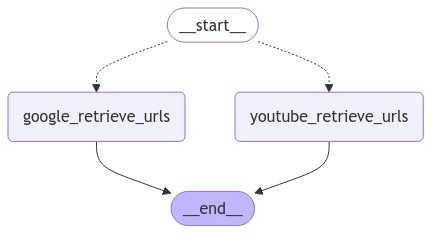

In [9]:
import operator
from typing_extensions import TypedDict
from typing import List, Annotated


class GraphState(TypedDict):
    """
    Graph state is a dictionary that contains information we want to propagate to, 
    and modify in, each graph node.
    """

    search_queries: List[str]  # List of search queries for the platform
    specific_questions: List[str]  # List of specific questions for content filtering
    platform: str  # Selected platform, e.g., 'google' or 'youtube'
    llm: object  # LLM instance for text generation
    llm_json_mode: object  # LLM instance for JSON-based output generation
    time_horizon: int  # Time horizon in days for filtering content
    max_outputs: int  # Maximum number of outputs to retrieve
    logger: object  # Logger object to track progress
    unique_urls: List[str]  # List of unique URLs retrieved from the platform
    all_docs: List[str]  # List of documents/content retrieved from URLs
    retriever: object  # Retriever object for semantic search
    relevant_chunks: dict  # Relevant content chunks based on questions
    qa_results: dict  # Q&A results after processing content
    valid_qa_results: dict  # Validated Q&A results without hallucinations
    summaries: dict  # Summaries for the processed sources
    sorted_sources: List[str]  # Sources ranked based on relevance to questions
    output_folder: str  # Folder path for saving results

# Define the workflow graph
workflow = StateGraph(GraphState)

# Add nodes
workflow.add_node("google_retrieve_urls", google_retrieve_urls)
workflow.add_node("youtube_retrieve_urls", youtube_retrieve_urls)
# workflow.add_node("google_process_content", google_process_content)
# workflow.add_node("youtube_process_content", youtube_process_content)
# workflow.add_node("create_embeddings", create_embeddings)
# workflow.add_node("semantic_search_and_grading", semantic_search_and_grading)
# workflow.add_node("generate_qa", generate_qa)
# workflow.add_node("hallucination_check", hallucination_check)
# workflow.add_node("generate_summaries", generate_summaries)
# workflow.add_node("rank_sources", rank_sources)
# workflow.add_node("save_output", save_output)

# Define edges
workflow.set_conditional_entry_point(
    route_platform,
    {
        "google_retrieve_urls": "google_retrieve_urls",
        "youtube_retrieve_urls": "youtube_retrieve_urls",
    },
)

# Platform-specific flows
workflow.add_edge("google_retrieve_urls", END)
workflow.add_edge("youtube_retrieve_urls", END)

# Merge flows after platform-specific processing
# workflow.add_edge("google_process_content", END)
# workflow.add_edge("youtube_process_content", END)

# # Continue common flow
# workflow.add_edge("create_embeddings", "semantic_search_and_grading")
# workflow.add_edge("semantic_search_and_grading", "generate_qa")
# workflow.add_edge("generate_qa", "hallucination_check")
# workflow.add_edge("hallucination_check", "generate_summaries")
# workflow.add_edge("generate_summaries", "rank_sources")
# workflow.add_edge("rank_sources", "save_output")
# workflow.add_edge("save_output", END)

# Compile the graph
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


# Run the Graph

In [10]:
# Execute the graph
initial_state = GraphState({
    "search_queries": SEARCH_QUERIES,
    "specific_questions": SPECIFIC_QUESTIONS,
    "platform": PLATFORM,
    "llm": llm,
    "llm_json_mode": llm_json_mode,
    "time_horizon": TIME_HORIZON,
    "max_outputs": MAX_OUTPUTS,
    "logger": logger,
})


In [11]:

for event in graph.stream(initial_state, stream_mode="values"):
    print(event)

INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0


{'search_queries': ['High-level overview of intelligent user interfaces and their impact on modern UI/UX design', 'Tools and frameworks for building intelligent user interfaces: A 2024 guide'], 'specific_questions': ['What are the latest trends in intelligent user interfaces, and how are they shaping user experience?', 'What are the best practices for ensuring accessibility and inclusivity in AI-powered user interfaces?'], 'platform': 'google', 'llm': ChatOllama(model='llama3.2:latest', temperature=0.0), 'llm_json_mode': ChatOllama(model='llama3.2:latest', temperature=0.0, format='json'), 'time_horizon': 185, 'max_outputs': 5, 'logger': <Logger __main__ (INFO)>, 'loop_step': 0}


INFO:__main__:Retrieved 20 unique URLs from Google.


{'search_queries': ['High-level overview of intelligent user interfaces and their impact on modern UI/UX design', 'Tools and frameworks for building intelligent user interfaces: A 2024 guide'], 'specific_questions': ['What are the latest trends in intelligent user interfaces, and how are they shaping user experience?', 'What are the best practices for ensuring accessibility and inclusivity in AI-powered user interfaces?'], 'platform': 'google', 'llm': ChatOllama(model='llama3.2:latest', temperature=0.0), 'llm_json_mode': ChatOllama(model='llama3.2:latest', temperature=0.0, format='json'), 'time_horizon': 185, 'max_outputs': 5, 'logger': <Logger __main__ (INFO)>, 'loop_step': 0, 'unique_urls': ['https://standards.ieee.org/initiatives/autonomous-intelligence-systems/standards/', 'https://www.ibm.com/products/watsonx-ai', 'https://www.codica.com/blog/ai-tech-stack-complete-guide/', 'https://iui.acm.org/2024/companion_proceedings.html', 'https://ux4sight.com/blog/designing-a-good-user-inte